In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc,roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import *
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import cross_val_score
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
from sklearn.utils import shuffle
import random
import gensim
import warnings
warnings.filterwarnings('ignore')
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Loading the Amazon Dataset

In [2]:
final_data=pd.read_csv('Amazon.csv')

# Sorting the Data based on the TimeStamp

In [3]:
final_data.sort_values('Time',ascending=True)
final_data.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


# Splliting the Dataset 

In [4]:
tscv=TimeSeriesSplit(n_splits=2)
for train_index,test_index in tscv.split(final_data):
    print("Train:", train_index,"Test:", test_index)
    train_data,test_data = final_data.iloc[train_index],final_data.iloc[test_index]

Train: [     0      1      2 ..., 121388 121389 121390] Test: [121391 121392 121393 ..., 242778 242779 242780]
Train: [     0      1      2 ..., 242778 242779 242780] Test: [242781 242782 242783 ..., 364168 364169 364170]


In [5]:
#Training data
train_data=shuffle(train_data)
reviews=train_data['Score']
reviews=reviews[0:70000]
train_data=train_data[0:70000]

In [6]:
#Test data
test_data=shuffle(test_data)
test_review=test_data['Score']
test_review=test_review[0:50000]
test_data=test_data[0:50000]

In [7]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"wouldn't", 'those', 'has', 'hadn', 'no', 'such', "shan't", 'when', "won't", 'should', "should've", 'ourselves', 'hers', 'are', 'some', "that'll", 'for', 'me', 'mightn', 'then', 'hasn', 'the', 's', 'same', 'will', 'mustn', "couldn't", 'both', 'am', "hadn't", 'them', 'own', 'theirs', "wasn't", 'themselves', 'haven', 'ma', 'your', 've', 'y', "mightn't", 'after', 'couldn', 'won', 'too', 'him', 'a', 'i', 'doing', 'yours', 'if', 'once', 'being', 'wasn', 'so', 'ain', 'below', 'shouldn', 'about', "doesn't", 'an', 'or', 'what', 'have', 'out', 'nor', 'he', 'as', 'why', 'this', 'our', 'that', 'up', 'you', 'herself', 'until', 'weren', 'other', 'wouldn', 'his', 'any', "needn't", 'is', 't', "isn't", "mustn't", 'do', 'between', "haven't", 'can', 'does', 'more', 'had', 'm', 'into', 'was', "you're", 're', 'while', 'again', 'isn', 'through', 'further', 'they', "it's", 'don', 'be', "you've", 'over', 'all', 'o', 'on', 'aren', 'my', 'by', 'there', 'from', 'doesn', 'yourself', 'needn', 'having', "aren't",

# Converting into the vectors using Word2vec

In [8]:
i=0
list_of_sent_train=[]
for sent in train_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [9]:
i=0
list_of_sent_test=[]
for sent in test_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [10]:
w2v_model_train=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_model_test=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)

In [11]:
tf_idf_vec=TfidfVectorizer()
train_tf_idf=tf_idf_vec.fit_transform(train_data['CleanText'].values)

test_tf_idf=tf_idf_vec.transform(test_data['CleanText'].values)

In [12]:
tf_idf_feat=tf_idf_vec.get_feature_names()
train_idf_sent_vectors=[];
#Storing each review/sentence in the list
row=0;
for sent in list_of_sent_train:#for each review/sentence
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        try:
            vec=w2v_model_train.wv[word]
            tfidf=train_tf_idf[row,tf_idf_feat.index(word)]
            sent_vec +=(vec*tfidf)
            weight_sum +=tfidf
        except:
            pass
    sent_vec /= weight_sum
    train_idf_sent_vectors.append(sent_vec)
    #print(tf_idf_sent_vectors)
    row += 1   

In [13]:
test_idf_sent_vectors=[];
#Storing each review/sentence in the list
row=0;
for sent in list_of_sent_test:#for each review/sentence
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        try:
            vec=w2v_model_test.wv[word]
            tfidf=test_tf_idf[row,tf_idf_feat.index(word)]
            sent_vec +=(vec*tfidf)
            weight_sum +=tfidf
        except:
            pass
    sent_vec /= weight_sum
    test_idf_sent_vectors.append(sent_vec)
    #print(tf_idf_sent_vectors)
    row += 1   

In [14]:
train_idf_sent_vectors_array=np.array(train_idf_sent_vectors)
train_idf_sent_vectors_array=np.nan_to_num(train_idf_sent_vectors_array)

test_idf_sent_vectors_array=np.array(test_idf_sent_vectors)
test_idf_sent_vectors_array=np.nan_to_num(test_idf_sent_vectors_array)


# Finding the optimal value of the depth using cross valdation

[0.8493571499868805, 0.85177154799533772, 0.85470008070816506, 0.8551001827571465, 0.85444269294781017, 0.85447153376472529, 0.85104289287842649, 0.84807162751166598, 0.84200008657143033, 0.83794292730495779, 0.83260022515510668, 0.82770002301428625, 0.82385725762973983, 0.81927153712799061, 0.81760000035918368, 0.81405731457259822, 0.81244323086618842, 0.80852866752099328, 0.80804295730699915, 0.80571444093294775, 0.8059715593055421, 0.80482855111895013, 0.80529983072040479, 0.80382866538425846, 0.80298580210175108, 0.80322855924956238, 0.80271426536151558]

The optimal number of neighbors is 6.


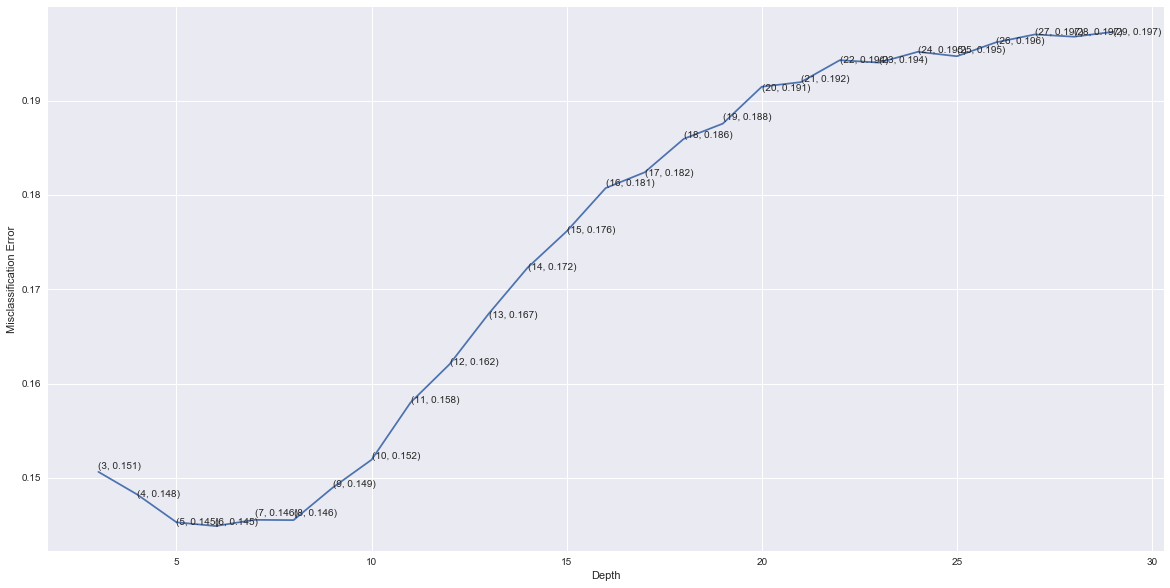

the misclassification error for each i value is :  [ 0.151  0.148  0.145  0.145  0.146  0.146  0.149  0.152  0.158  0.162
  0.167  0.172  0.176  0.181  0.182  0.186  0.188  0.191  0.192  0.194
  0.194  0.195  0.195  0.196  0.197  0.197  0.197]


In [15]:
depth = list(range(3,30))
#depth = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []

# perform 10-fold cross validation
for i in depth:
    dt = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(dt, train_idf_sent_vectors_array,reviews, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_i = depth[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_i)

# plot misclassification error vs k 
plt.figure(figsize=(20,10))
plt.plot(depth, MSE)

for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each i value is : ", np.round(MSE,3))

In [25]:
tree=DecisionTreeClassifier(max_depth=6)

In [26]:
tree.fit(train_idf_sent_vectors_array,reviews)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Prediction and Evaluation

In [27]:
prediction=tree.predict(test_idf_sent_vectors_array)

In [28]:
print(classification_report(test_review,prediction))

             precision    recall  f1-score   support

          0       0.53      0.02      0.04      8257
          1       0.84      1.00      0.91     41743

avg / total       0.79      0.84      0.77     50000



In [29]:
confu_metric=confusion_matrix(test_review,prediction)
print(confu_metric)

[[  150  8107]
 [  133 41610]]


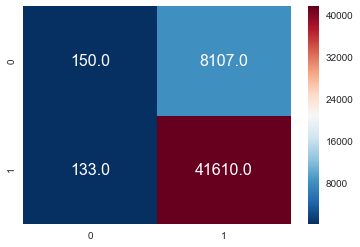

In [30]:
sns.heatmap(confu_metric,annot=True,fmt='.1f',annot_kws={"size": 16},cmap='RdBu_r')

# Train and Test Metric

In [31]:
TP=confu_metric[1][1]
FP=confu_metric[0][1]
TN=confu_metric[0][0]
FN=confu_metric[1][0]

In [32]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.996813837051
FPR:  0.981833595737
Specificity:  0.018166404263
Precision:  0.836937063781
Recall:  0.996813837051
F1Score:  0.909905969823


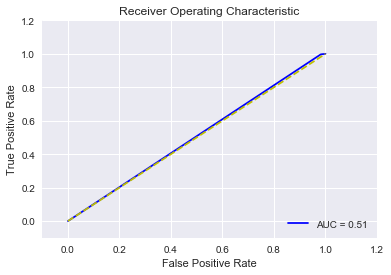

In [33]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,prediction)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion and Summary

1.I have preprocessed and cleaned  the whole dataset and store in Amazon.csv file for the further use. That CSV contains all the data. 
2. Now We have cleaned data , So I have sorted the Whole data on the basic of the TimeStamp
3. Now I have splitted my whole Dataset into Training,Cross validation and Test datasets for My ML
4. I have taken the 70K sample from the Training purpose and 30K Sample for Testing purpose and another 30K for cross validation
5. Its time to convert our text into vectors . I have used weighted tfidf to convert my text reviews into Vectors . 
   I have converted the Training Sample, Test sample individually

7. First I have used cross validation technique to find the best depth for my decision tree 
8. I have plot the curve between MSE and No. of depth
9. I have applied DecisionTreeClassifier() using best depth. 
10. I have predicted and evaluated the test data using classificationreport and confusion matrix
11. I have also found different test and train metric and on the basic of that I have drawn Roc cuve   